In [286]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
import matplotlib as mpl
from numpy import concatenate as cat
from collections import defaultdict
from sklearn import metrics
mpl.rcParams['figure.dpi'] = 250
pd.set_option('precision', 3)
DATASET = 'tbi'

# if 'tbi' in DATASET or 'csi' in DATASET:
seeds = sorted([
    int(path.split('_')[-1]) for path in glob.glob(f'results/{DATASET}/seed_*')])

if DATASET == 'sim':
    sens_levels = []
    metrics_ = ['auc', 'aps', 'acc', 'f1']
elif 'iai' not in DATASET:
    sens_levels = [0.92, 0.94, 0.96, 0.98]
    metrics_ = ['high_spec_avg', 'spec_0.92', 'spec_0.94', 'spec_0.96', 'spec_0.98', 'auc', 'aps', 'acc', 'f1']
else:
    sens_levels = [0.92, 0.94, 0.96, 0.98]
    metrics_ = ['high_spec_avg', 'spec_0.92', 'spec_0.94', 'spec_0.96', 'spec_0.98', 'auc', 'aps', 'acc', 'f1']

In [287]:
def plott(model_name, sens, spec, ppv, ax):
    if 'pecarn' in model_name.lower():
        # ax.plot(sens[0], spec[0], '.-', label=model_name)
        pass
    elif 'mix' not in model_name.lower() and 'pcart' not in model_name.lower():
        ax.plot(sens, spec, '.-', label=model_name)

In [288]:
def multiplot(paths, ax, suffix=""):
    for model_file in paths:
        basename = os.path.basename(model_file).split('.')[0]
        dct = pkl.load(open(model_file, 'rb'))
        plott(basename, dct['sens_tune'], dct['spec_tune'], dct['ppv_tune'], ax)
    ax.legend(frameon=False, loc='best')
    ax.set_xlim(0.9, 1)
    # ax.set_ylim(0, 0.2)

In [289]:
def multiseedplot(group='all'):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for k, seed in enumerate(seeds[:9]):
        paths = sorted(glob.glob(f'results/{DATASET}/seed_{seed}/{group}/*.pkl'))
        multiplot(paths, axes[k // 3, k % 3], group)
    plt.xlabel('sens')
    plt.ylabel('spec')
    plt.tight_layout()

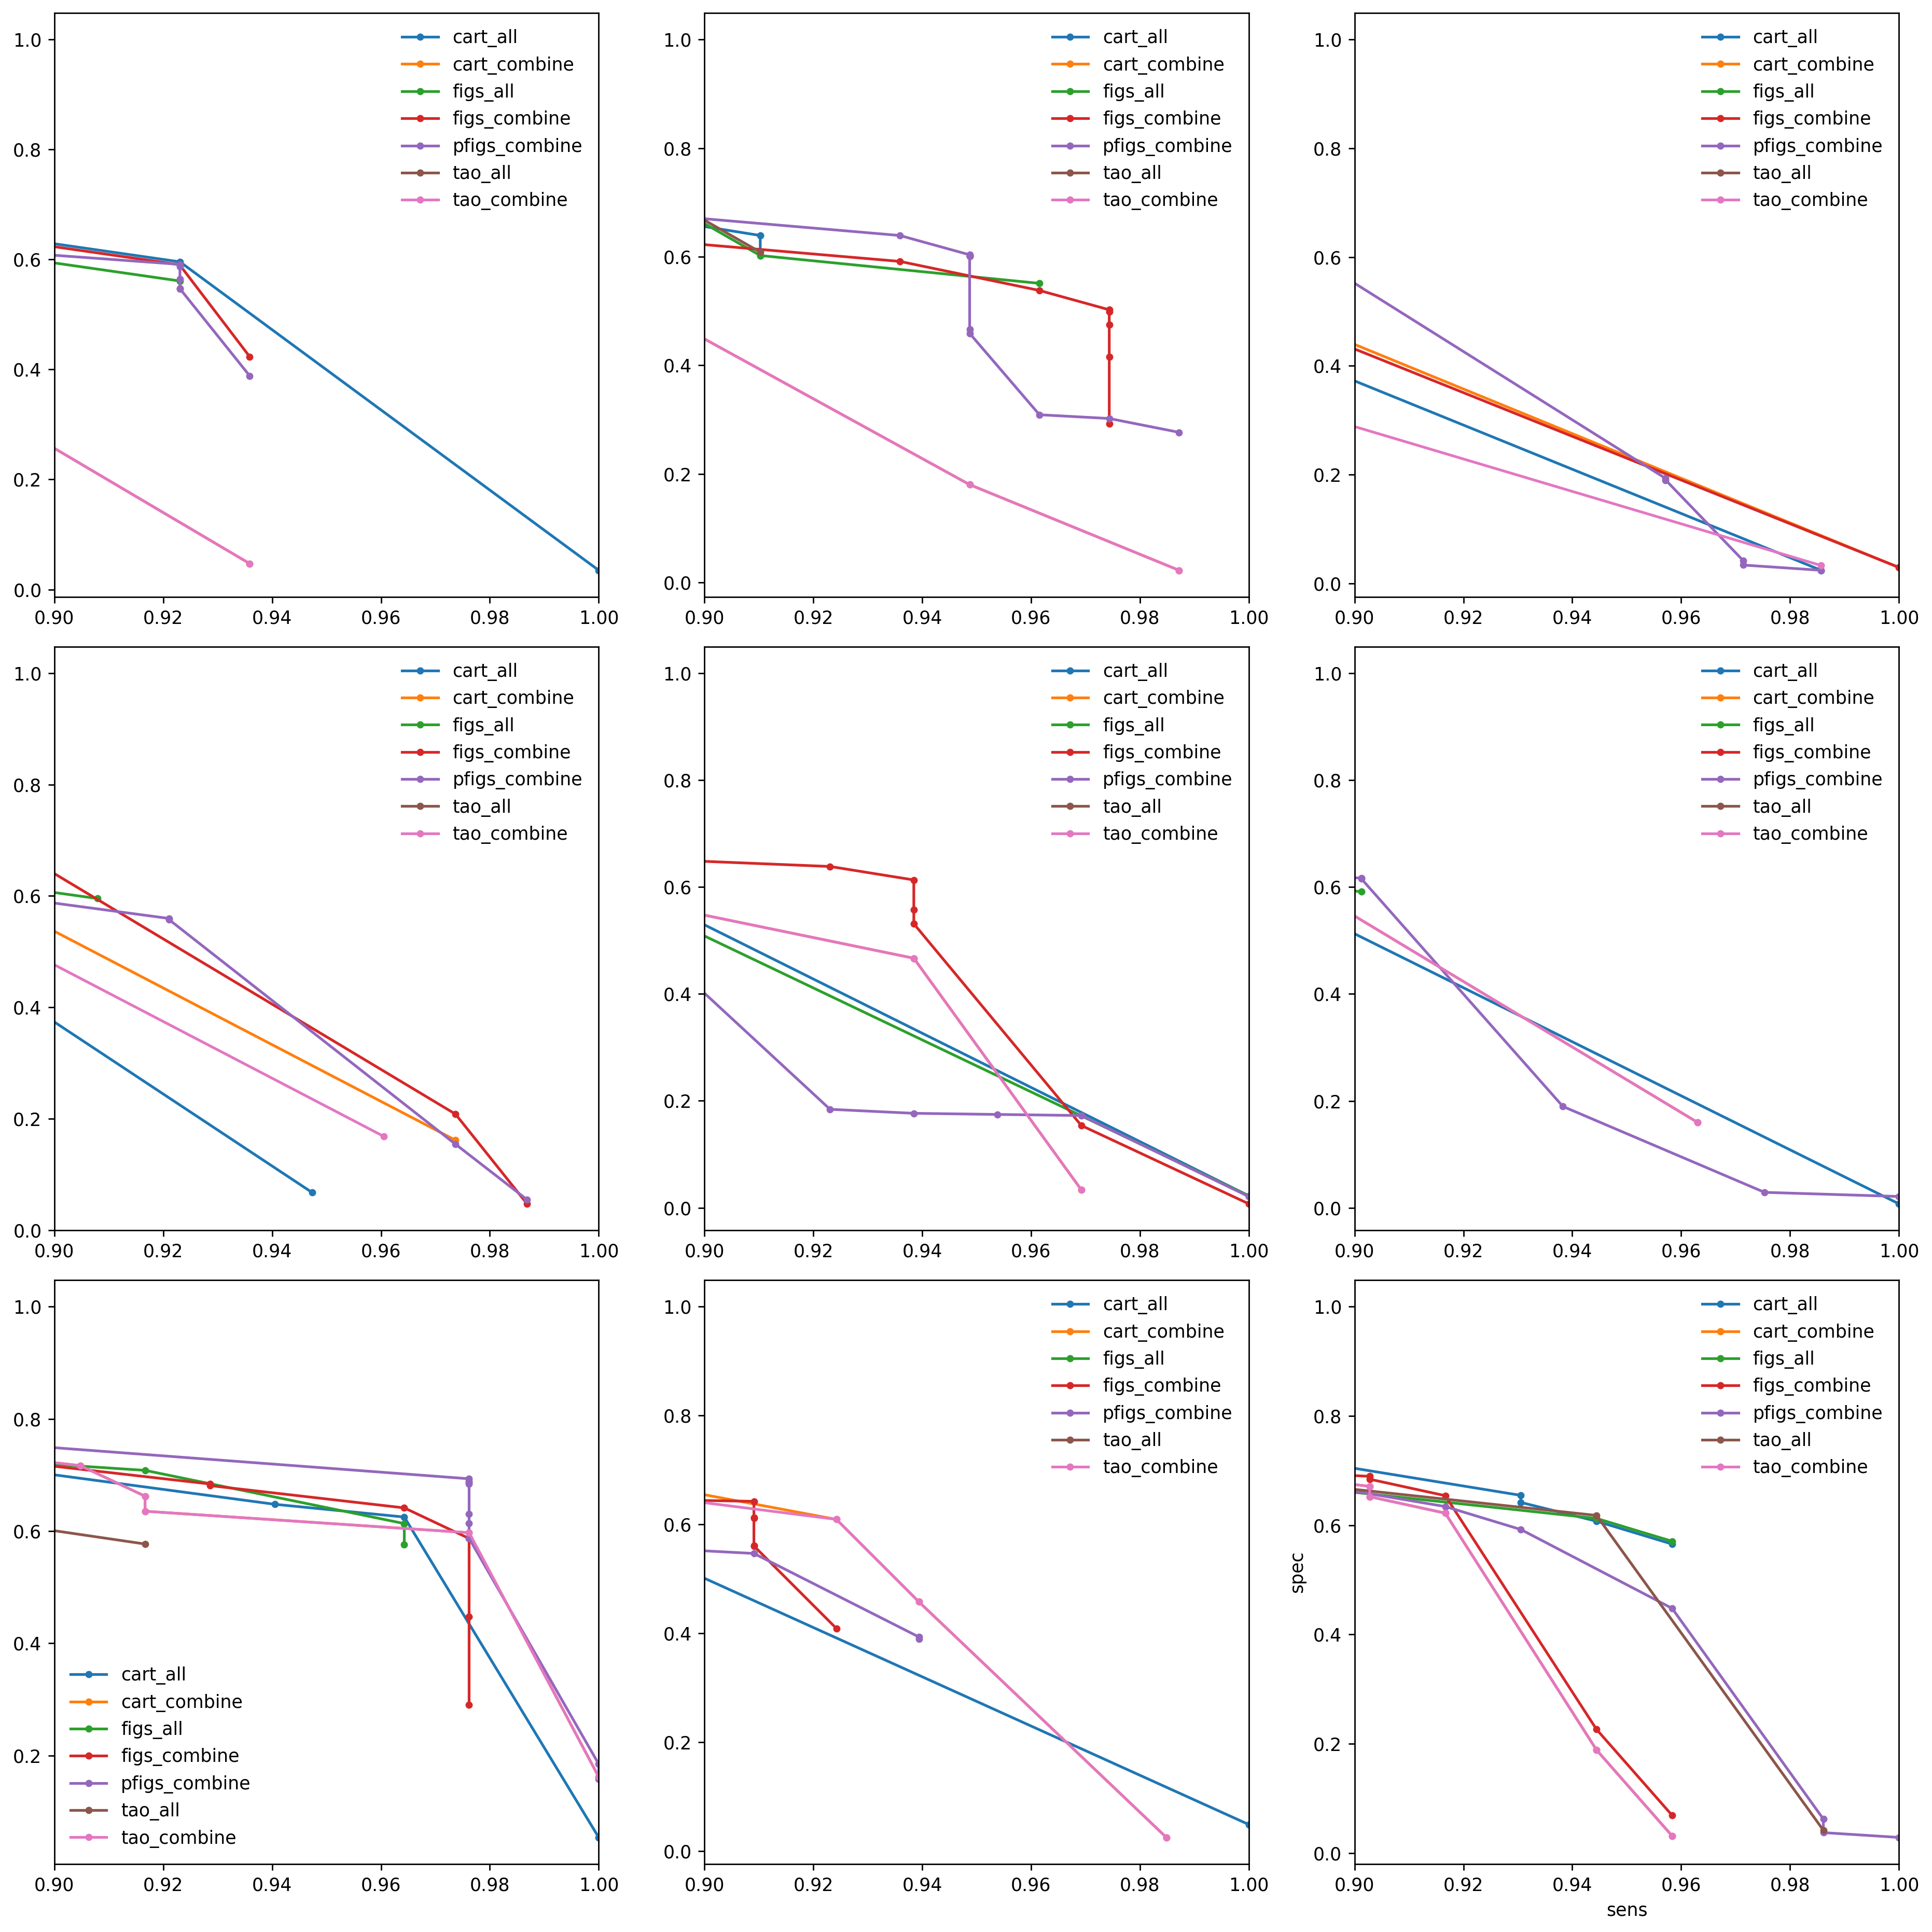

In [290]:
multiseedplot()

In [291]:
# multiseedplot(group='young')

In [292]:
# multiseedplot(group='old')

In [298]:
def pkl_to_table(group):
    table = defaultdict(lambda:[])
    for i in seeds:

        seed_paths = sorted(glob.glob(f'results/{DATASET}/seed_{i}/{group}/*.pkl'))
        table_index = [os.path.basename(f).split('.')[0] for f in seed_paths]
        for model_file in seed_paths:
            dct = pkl.load(open(model_file, 'rb'))
            specs = np.array(dct['spec_tune'])
            senses = np.array(dct['sens_tune'])
            precisions = np.array(dct['ppv_tune'])
            for sens in sens_levels:
                table[f'spec_{sens}_seed_{i}'].append(
                    np.max(specs[senses > sens]) if specs[senses > sens].shape[0] > 0 else 0.0)
            table[f'auc_seed_{i}'].append(metrics.auc(1 - specs, senses))
            # table[f'auprc_seed_{i}'].append(metrics.auc(senses, np.nan_to_num(precisions, nan=1)))
            table[f'aps_seed_{i}'].append(-np.sum(np.diff(senses) * np.array(precisions)[:-1]))
            table[f'acc_seed_{i}'].append(dct['acc'])
            table[f'f1_seed_{i}'].append(dct['f1'])
        
    res_table = pd.DataFrame(table, index=table_index)
    if sens_levels:
        for i in seeds:
            res_table[f'high_spec_avg_seed_{i}'] = res_table.loc[
                :, [f'spec_0.92_seed_{i}', f'spec_0.94_seed_{i}', f'spec_0.96_seed_{i}', f'spec_0.98_seed_{i}']].mean(axis=1)

    for metric in metrics_:
        res_table_metric = res_table.loc[:, res_table.columns.str.contains(metric)]
        res_table[metric] = res_table_metric.mean(axis=1)

    # res_table['high_spec_avg'] = res_table[
    #     [f'spec_0.94', f'spec_0.96', f'spec_0.98']].mean(axis=1)

    for metric in metrics_:
        res_table_metric = res_table.loc[:, res_table.columns.str.contains(metric)]
        res_table[f'{metric}_std_err'] = res_table_metric.std(axis=1) / np.sqrt(10)
        # res_table[f'{metric}_std'] = res_table_metric.std(axis=1)
        
    return res_table

In [299]:
# pkl_to_table('all').to_csv(f'results/{DATASET}/all_average.csv')
# pkl_to_table('young').to_csv(f'results/{DATASET}/young_average.csv')
# pkl_to_table('old').to_csv(f'results/{DATASET}/old_average.csv')

In [300]:
pkl_to_table('all').iloc[:, -17:].style.background_gradient()#highlight_max(color='blue')

,spec_0.92,spec_0.94,spec_0.96,spec_0.98,auc,aps,acc,f1,high_spec_avg_std_err,spec_0.92_std_err,spec_0.94_std_err,spec_0.96_std_err,spec_0.98_std_err,auc_std_err,aps_std_err,acc_std_err,f1_std_err
cart_all,0.209,0.148,0.078,0.021,0.702,0.057,0.772,0.057,0.050,0.088,0.076,0.058,0.006,0.064,0.004,0.007,0.002
cart_combine,0.266,0.138,0.103,0.024,0.753,0.049,0.772,0.056,0.040,0.064,0.054,0.055,0.015,0.018,0.004,0.008,0.002
cart_mix,0.280,0.140,0.109,0.028,0.790,0.053,0.782,0.059,0.041,0.070,0.053,0.055,0.015,0.016,0.004,0.007,0.002
figs_all,0.238,0.182,0.121,0.004,0.380,0.040,0.710,0.048,0.056,0.090,0.085,0.073,0.003,0.069,0.003,0.008,0.002
figs_combine,0.399,0.197,0.175,0.026,0.619,0.045,0.726,0.051,0.048,0.079,0.068,0.070,0.016,0.051,0.003,0.010,0.002
figs_mix,0.412,0.235,0.181,0.027,0.686,0.048,0.715,0.049,0.045,0.065,0.080,0.063,0.014,0.044,0.003,0.011,0.002
pcart_combine,0.155,0.135,0.064,0.030,0.758,0.044,0.764,0.055,0.035,0.055,0.057,0.022,0.015,0.014,0.002,0.009,0.002
pcart_mix,0.300,0.235,0.120,0.067,0.792,0.054,0.766,0.056,0.049,0.066,0.069,0.059,0.023,0.012,0.003,0.007,0.002
pecarn_combine,0.567,0.567,0.454,0.057,0.209,0.019,0.571,0.038,0.024,0.001,0.001,0.072,0.054,0.001,0.001,0.001,0.001
pfigs_combine,0.419,0.230,0.147,0.064,0.696,0.041,0.705,0.047,0.052,0.066,0.078,0.065,0.028,0.043,0.002,0.006,0.002


In [301]:
s = '6'
pkl_to_table('all').iloc[[0, 1, 11, 12, 3, 4, 9], :].loc[:, [f'spec_0.92_seed_{s}', f'spec_0.94_seed_{s}', f'spec_0.96_seed_{s}', f'spec_0.98_seed_{s}']
    ].style.background_gradient()#highlight_max(color='blue')

,spec_0.92_seed_6,spec_0.94_seed_6,spec_0.96_seed_6,spec_0.98_seed_6
cart_all,0.648,0.648,0.625,0.054
cart_combine,0.597,0.597,0.597,0.162
tao_all,0.000,0.000,0.000,0.000
tao_combine,0.597,0.597,0.597,0.162
figs_all,0.613,0.613,0.613,0.000
figs_combine,0.684,0.641,0.641,0.000
pfigs_combine,0.693,0.693,0.693,0.185


In [302]:
pkl_to_table('young').iloc[:, -15:].drop('pecarn_young').style.background_gradient()#highlight_max(color='blue')

,spec_0.96,spec_0.98,auc,aps,acc,f1,high_spec_avg_std_err,spec_0.92_std_err,spec_0.94_std_err,spec_0.96_std_err,spec_0.98_std_err,auc_std_err,aps_std_err,acc_std_err,f1_std_err
cart_all,0.071,0.012,0.640,0.073,0.807,0.069,0.052,0.087,0.087,0.055,0.006,0.080,0.009,0.009,0.006
cart_young,0.083,0.083,0.496,0.050,0.801,0.070,0.070,0.092,0.084,0.069,0.069,0.084,0.010,0.015,0.007
figs_all,0.059,0.001,0.351,0.041,0.692,0.050,0.051,0.094,0.096,0.055,0.001,0.065,0.005,0.013,0.003
figs_young,0.130,0.067,0.480,0.052,0.775,0.064,0.063,0.085,0.084,0.078,0.058,0.080,0.011,0.012,0.005
pcart_young,0.087,0.087,0.572,0.042,0.800,0.068,0.072,0.084,0.085,0.070,0.070,0.075,0.004,0.009,0.005
pfigs_young,0.137,0.075,0.579,0.037,0.745,0.056,0.076,0.083,0.083,0.086,0.070,0.076,0.004,0.016,0.004
tao_all,0.000,0.000,0.267,0.045,0.737,0.054,0.033,0.065,0.065,0.000,0.000,0.052,0.005,0.020,0.004
tao_young,0.083,0.083,0.494,0.050,0.804,0.070,0.070,0.092,0.084,0.069,0.069,0.085,0.010,0.014,0.007


In [282]:
pkl_to_table('old').iloc[:, -15:].drop('pecarn_old').style.background_gradient()#highlight_max(color='blue')

,spec_0.96,spec_0.98,auc,aps,acc,f1,high_spec_avg_std_err,spec_0.92_std_err,spec_0.94_std_err,spec_0.96_std_err,spec_0.98_std_err,auc_std_err,aps_std_err,acc_std_err,f1_std_err
cart_all,0.148,0.021,0.701,0.053,0.761,0.054,0.056,0.088,0.077,0.073,0.007,0.064,0.002,0.007,0.002
cart_old,0.073,0.008,0.627,0.048,0.761,0.054,0.048,0.086,0.076,0.054,0.004,0.078,0.003,0.010,0.002
figs_all,0.181,0.005,0.389,0.043,0.717,0.048,0.062,0.092,0.084,0.084,0.003,0.070,0.003,0.010,0.002
figs_old,0.187,0.063,0.557,0.046,0.710,0.047,0.070,0.089,0.086,0.084,0.051,0.062,0.003,0.011,0.002
pcart_old,0.072,0.008,0.514,0.043,0.752,0.052,0.045,0.090,0.056,0.056,0.005,0.081,0.002,0.010,0.002
pfigs_old,0.195,0.053,0.585,0.041,0.691,0.045,0.066,0.090,0.098,0.088,0.034,0.075,0.002,0.009,0.002
tao_all,0.061,0.003,0.304,0.040,0.753,0.052,0.045,0.077,0.058,0.058,0.003,0.057,0.003,0.013,0.001
tao_old,0.074,0.005,0.622,0.047,0.772,0.055,0.048,0.086,0.075,0.054,0.003,0.077,0.003,0.011,0.001
